In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from sklearn.preprocessing import FunctionTransformer
# from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


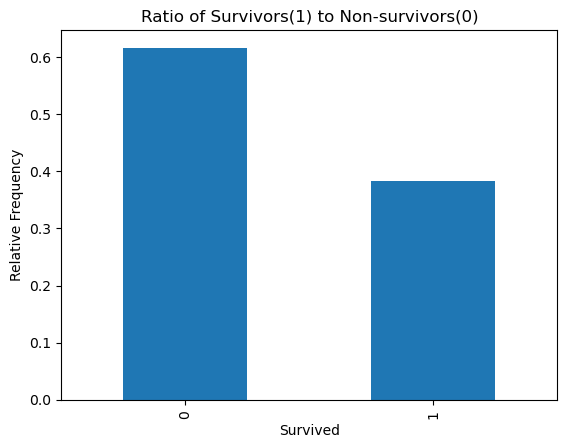

In [5]:
df['Survived'].value_counts(normalize = True).plot(kind = 'bar')
plt.ylabel('Relative Frequency')
plt.title('Ratio of Survivors(1) to Non-survivors(0)');

In [6]:
def fix_outlier(data, col):
    q1, q3 = (data[col]).quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_threshold = q1 - 1.5 * iqr
    upper_threshold = q3 + 1.5 * iqr
    return data[(data[col] >= lower_threshold) & (data[col] <= upper_threshold)]

In [7]:
df = fix_outlier(df, 'Fare')

### Feature Engineering

In [9]:
def binning_func(col):
    '''Bin age into groups
    '''
    age = col[:, 0]
    bins =  [-np.inf, 18, 40, 60, np.inf]
    labels = ['infant/child', 'young adult', 'adult', 'senior']
    
    return pd.cut(age, bins = bins, labels = labels).astype('str')

In [10]:
def log_transform(col):
    '''transform feature using log transformation''' 
    return np.log1p(col)

In [11]:
def binary_encoder(col):
    return np.where(col == 'male', 1, 0)

In [12]:
log_transformer = FunctionTransformer(log_transform)
binning_transformer = FunctionTransformer(binning_func, validate = True)
encode_transformer = FunctionTransformer(binary_encoder)

### Preprocessing and Transformation

In [14]:
# divide data into X matrix and y vector
target = 'Survived'
X = df.drop(target, axis = 1)
y = df[target]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42, test_size = 0.2)

In [16]:
# select features with different transformation
numerical_features = ['SibSp', 'Parch']
age_col = ['Age']
log_fare = ['Fare']
sex_col = ['Sex']
categorical_features = ['Pclass', 'Embarked']
drop_feat = ['PassengerId', 'Name','Ticket', 'Cabin']

In [17]:
numerical_pipeline = Pipeline(
    steps = [
        ('imputer', SimpleImputer()),
        ('scaler', StandardScaler())]
)

In [18]:
cat_pipeline = Pipeline(
    steps = [('cat_imputer', SimpleImputer(strategy = 'constant', fill_value = 'not specified')),
              ('ohe', OneHotEncoder(handle_unknown = 'ignore', use_cat_names = True))]
)

In [19]:
fare_pipeline = Pipeline(
    steps = [
        ('impute', SimpleImputer()),
        ('log', log_transformer),
        
    ]
)

In [20]:
sex_pipeline = Pipeline(
    steps = [
        ('fill', SimpleImputer(strategy = 'most_frequent')),
        ('replace', encode_transformer)
    ]
)

In [21]:
age_pipeline = Pipeline(steps = [
     ('cat_imputer', SimpleImputer()),
     ('bin', binning_transformer),
     ('ohe', OneHotEncoder(handle_unknown = 'ignore', use_cat_names = True))
   
])

In [22]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features),
        ('age', age_pipeline, age_col),
        ('sex', sex_pipeline, sex_col),
        ('fare', fare_pipeline, log_fare)
    ], remainder = 'drop'
)

In [23]:
np.isnan(preprocessor.fit_transform(X_train)).sum()

0

In [24]:
# preprocessor['num'].get_features_names()

### Model Selection

In [26]:
log_reg = Pipeline(
    steps = [('preprocessing', preprocessor),
        ('log_reg', LogisticRegression(random_state = 42)) ]
)

In [27]:
dt = Pipeline(
    steps = [('preprocessing', preprocessor),
        ('dt_clf', DecisionTreeClassifier(random_state = 42)) ]
)

In [28]:
rf_clf = Pipeline(
    steps = [('preprocessing', preprocessor),
        ('randomforest', RandomForestClassifier(random_state = 42)) ]
)

In [29]:
svm = Pipeline(
    steps = [('preprocessing', preprocessor),
        ('svm', SVC(random_state = 42)) ]
)

In [30]:
xgb = Pipeline(
    steps = [('preprocessing', preprocessor),
        ('xgb', XGBClassifier()) ]
)

In [31]:
knn = Pipeline(
    steps = [('preprocessing', preprocessor),
        ('knn', KNeighborsClassifier())]
)

In [32]:
models = {
    'logisticregression' : log_reg,
    'decisiontree' : dt,
    'randomforest': rf_clf,
    'svm' : svm,
    'xgboost' : xgb,
    'knn' : knn
}

In [33]:
result= []
for model in models.values():
    kf  = KFold(n_splits = 5, shuffle = True, random_state = 42)
    cv_result = cross_val_score(model, X_train, y_train, cv = kf)
    result.append(cv_result)

In [34]:
print(result)

[array([0.83064516, 0.72580645, 0.87903226, 0.71774194, 0.76612903]), array([0.85483871, 0.81451613, 0.87903226, 0.74193548, 0.80645161]), array([0.82258065, 0.81451613, 0.88709677, 0.77419355, 0.82258065]), array([0.82258065, 0.75      , 0.85483871, 0.75806452, 0.82258065]), array([0.85483871, 0.83064516, 0.86290323, 0.78225806, 0.83064516]), array([0.79032258, 0.74193548, 0.81451613, 0.7016129 , 0.81451613])]


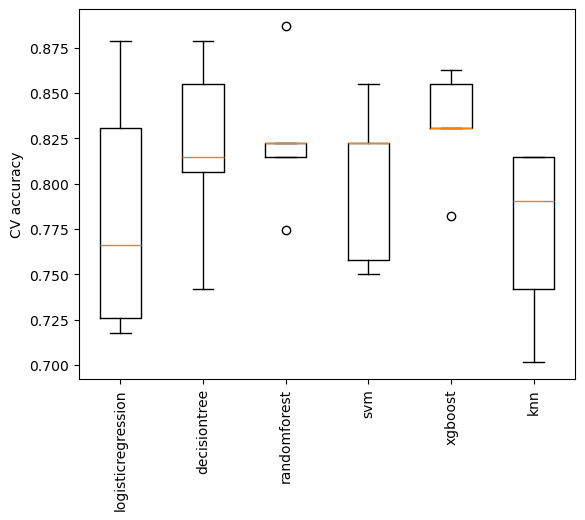

In [35]:
plt.boxplot(result, labels = models.keys())
plt.xticks(rotation = 90)
plt.ylabel('CV accuracy');

### Hyperparameter Tuning

In [37]:
# param_grid = {
    
 # }

In [38]:
# models['xgboost'].named_steps['xgb'].get_params()

In [39]:
xgb_params_grid = {
    'xgb__learning_rate' : np.linspace(0.01, 0.3),
    'xgb__max_depth' : np.arange(2, 5, 2),
}

In [40]:
kf  = KFold(n_splits = 5, shuffle = True, random_state = 42)

In [41]:
xgb_cv = GridSearchCV(xgb, cv = kf, param_grid = xgb_params_grid, n_jobs = -1)

In [42]:
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['SibSp',
                                                                          'Parch']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('cat_imputer',
                                                                                          SimpleImputer(fill_value='not '
                                                                                                                   'specified',
                                                                                                        strategy='constant')),
                                                                                         ('ohe',
                                                                                          One...
       0.12836735, 0.13428571, 0.14020408, 0.14612245, 0.15204082,
       0.15795918, 0.16387755, 0.16979592, 0.17571429, 0.18163265,
       0.18755102, 0.19346939, 0.19938776, 0.20530612, 0.21122449,
       0.21714286, 0.22306122, 0.22897959, 0.23489796, 0.24081633,
       0.24673469, 0.25265306, 0.25857143, 0.2644898 , 0.27040816,
       0.27632653, 0.2822449 , 0.28816327, 0.29408163, 0.3       ]),
                         'xgb__max_depth': array([2, 4])})

In [43]:
print(xgb_cv.best_score_)
print(xgb_cv.best_params_)

0.8370967741935484
{'xgb__learning_rate': 0.19346938775510206, 'xgb__max_depth': 4}


In [44]:
best_model = xgb_cv.best_estimator_

In [45]:
best_model = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('best_model',  XGBClassifier(random_state = 0, learning_rate = 0.09, max_depth = 4))
        
    ]
)

In [46]:
best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SibSp', 'Parch']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='not '
                                                                                            'specified',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 use_cat_names=True))]),
                                                  ['Pclass', 'Embar...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.09,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=0, ...))])

## Evaluate on Validation

In [48]:
best_model.score(X_test, y_test)

0.7806451612903226

### Evaluate Test set

In [50]:
test_df= pd.read_csv('data/test.csv')

In [51]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [52]:
y_pred_df = best_model.predict(X_test)

In [53]:
test_copy =  test_df.copy()

In [54]:
test_copy['predicted'] = pd.Series(y_pred_df)

In [55]:
test_copy.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,predicted
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0.0


In [56]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SibSp', 'Parch']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='not '
                                                                                            'specified',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 use_cat_names=True))]),
                                                  ['Pclass', 'Embar...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.09,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=0, ...))])

# Communication of Results

In [57]:
best_model['preprocessor'].transformers_

[('num',
  Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())]),
  ['SibSp', 'Parch']),
 ('cat',
  Pipeline(steps=[('cat_imputer',
                   SimpleImputer(fill_value='not specified',
                                 strategy='constant')),
                  ('ohe',
                   OneHotEncoder(cols=[0, 1], handle_unknown='ignore',
                                 use_cat_names=True))]),
  ['Pclass', 'Embarked']),
 ('age',
  Pipeline(steps=[('cat_imputer', SimpleImputer()),
                  ('bin',
                   FunctionTransformer(func=<function binning_func at 0x1305479c0>,
                                       validate=True)),
                  ('ohe',
                   OneHotEncoder(cols=[0], handle_unknown='ignore',
                                 use_cat_names=True))]),
  ['Age']),
 ('sex',
  Pipeline(steps=[('fill', SimpleImputer(strategy='most_frequent')),
                  ('replace',
                   FunctionTransformer(func=<func

In [58]:
# extract each transformers in the ColumnTransformer
t1 = preprocessor.transformers_[0]
t2 = preprocessor.transformers_[1]
t3= preprocessor.transformers_[2]
t4 = preprocessor.transformers_[3]
t5 = preprocessor.transformers_[4]

In [59]:
# num
f1 = t1[1].named_steps['scaler'].get_feature_names_out(t1[2])
f1

array(['SibSp', 'Parch'], dtype=object)

In [60]:
# cat
f2 = t2[1].named_steps['ohe'].get_feature_names_out(t2[2])
f2

array(['0_3.0', '0_1.0', '0_2.0', '1_S', '1_C', '1_Q'], dtype=object)

In [61]:
# Age
f3 = t3[1].named_steps['ohe'].get_feature_names_out(t3[2])
f3

array(['0_infant/child', '0_young adult', '0_adult', '0_senior'],
      dtype=object)

In [62]:
# sex
f4 = t4[1].named_steps['fill'].get_feature_names_out(t4[2])
f4

array(['Sex'], dtype=object)

In [63]:
# Fare
f5 = t5[1].named_steps['impute'].get_feature_names_out(t5[2])
f5

array(['Fare'], dtype=object)

In [ ]:
feature_names = list(f1) + list(f2) + list(f3) + list(f4) + list(f5)
feature_names

In [65]:
importance = best_model['best_model'].feature_importances_
importance

array([0.02899412, 0.06791674, 0.10598791, 0.02069234, 0.06982124,
       0.01129288, 0.03675693, 0.05741778, 0.03584752, 0.0143724 ,
       0.02128293, 0.05129544, 0.4457985 , 0.03252323], dtype=float32)

## Odds Ratio

In [67]:
feature_importance = pd.Series(np.exp(importance), index = feature_names).sort_values()

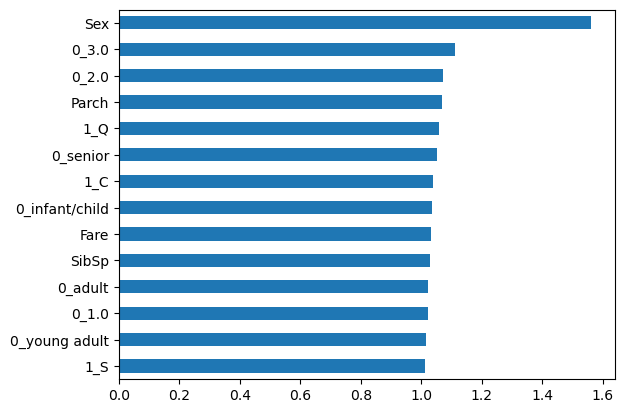

In [68]:
feature_importance.plot(kind = 'barh');

## Save Model

In [70]:
import pickle

In [71]:
# with open('models/xgb.pkl', 'wb') as file:
#     pickle.dump(best_model, file)